## Access this Notebook
You can launch this notebook in the US GHG Center JupyterHub by clicking the link below. If you are a new user, you should first sign up for the hub by filling out this [**request form**](https://docs.google.com/forms/d/e/1FAIpQLSdai8otCdrVQzJgev8mjDhzKyCg7jcrB3UeTXNHoCiaMKrkaQ/viewform) and providing the required information. 


Access the [**ODIAC Fossil Fuel CO₂ Emissions**](https://us-ghg-center.github.io/ghgc-docs/user_data_notebooks/odiac-ffco2-monthgrid-v2023_User_Notebook.html) notebook in the US GHG Center JupyterHub. 

## Table of Contents
- [Data Summary and Application](#data-summary-and-application)
- [Approach](#approach)
- [About the Data](#about-the-data)
- [Install the Required Libraries](#install-the-required-libraries)
- [Query the STAC API](#query-the-stac-api)
- [Visual Comparison Across Time Periods](#visual-comparison-across-time-periods)
- [Map Out Selected Tiles](#map-out-selected-tiles)
- [Calculate Zonal Statistics](#calculate-zonal-statistics)
- [Time-Series Analysis](#time-series-analysis)
- [Summary](#summary)

## Data Summary and Application
- **Spatial coverage**: Global
- **Spatial resolution**: 1 km x 1 km
- **Temporal extent**: January 2000 - December 2022
- **Temporal resolution**: Monthly
- **Unit**: Metric tonnes of carbon per 1 km x 1 km cell per month
- **Utility**: Climate Research

For more, visit the [ODIAC Fossil Fuel CO₂ Emissions](https://earth.gov/ghgcenter/data-catalog/odiac-ffco2-monthgrid-v2023) data overview page.  

## Approach

   1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. Collection processed in this notebook is ODIAC CO₂ emissions version 2024.
   2. Pass the STAC item into raster API `/collections/{collection_id}/items/{item_id}/tilejson.json` endpoint
   3. We'll visualize two tiles (side-by-side) allowing for comparison of each of the time points using `folium.plugins.DualMap`
   4. After the visualization, we'll perform zonal statistics for a given polygon.
   

## About the Data
### ODIAC Fossil Fuel CO₂ Emissions 

The Open-Data Inventory for Anthropogenic Carbon dioxide (ODIAC) is a high-spatial resolution global emission data product of CO₂ emissions from fossil fuel combustion (Oda and Maksyutov, 2011). ODIAC pioneered the combined use of space-based nighttime light data and individual power plant emission/location profiles to estimate the global spatial extent of fossil fuel CO₂ emissions. With the innovative emission modeling approach, ODIAC achieved the fine picture of global fossil fuel CO₂ emissions at a 1x1km.

For more information regarding this dataset, please visit the [ODIAC Fossil Fuel CO₂ Emissions](https://earth.gov/ghgcenter/data-catalog/odiac-ffco2-monthgrid-v2022) data overview page.

## Terminology
Navigating data via the GHGC API, you will encounter terminology that is different from browsing in a typical filesystem. We'll define some terms here which are used throughout this notebook.
- `catalog`:    All datasets available at the `/stac` endpoint
- `collection`: A specific dataset, e.g. ODIAC Fossil Fuel CO<sub>2</sub> Emissions
- `item`:       One granule in the dataset, e.g. one monthly file of CO<sub>2</sub> emissions
- `asset`:      A variable available within the granule, e.g. fossil fuel CO<sub>2</sub> emisisons
- `STAC API`:   **Sp**atio**T**emporal **A**sset **C**atalogs - Endpoint for fetching metadata about available datasets
- `Raster API`: Endpoint for fetching data itself, for imagery and statistics

# Install the Required Libraries
Required libraries are pre-installed on the GHG Center Hub. If you need to run this notebook elsewhere, please install them with this line in a code cell:

%pip install requests folium rasterstats pystac_client pandas matplotlib --quiet

In [1]:
# Import the following libraries
# For fetching from the Raster API
import requests
# For making maps
import folium
import folium.plugins
from folium import Map, TileLayer
# For talking to the STAC API
from pystac_client import Client
# For working with data
import pandas as pd
# For making time series
import matplotlib.pyplot as plt
# For formatting date/time data
import datetime
# Custom functions for working with GHGC data via the API
import ghgc_utils

# Query the STAC API
**STAC API Collection Names**

Now, you must fetch the dataset from the [**STAC API**](https://earth.gov/ghgcenter/api/stac/) by defining its associated STAC API collection ID as a variable. 
The collection ID, also known as the **collection name**, for the ODIAC Fossil Fuel CO<sub>2</sub> Emissions dataset is [**odiac-ffco2-monthgrid-v2023**](https://earth.gov/ghgcenter/api/stac/collections/odiac-ffco2-monthgrid-v2024).*

**You can find the collection name of any dataset on the GHGC data portal by navigating to the dataset landing page within the data catalog. The collection name is the last portion of the dataset landing page's URL, and is also listed in the pop-up box after clicking "ACCESS DATA."*

In [2]:
# Provide the STAC and RASTER API endpoints
# The endpoint is referring to a location within the API that executes a request on a data collection nesting on the server.

# The STAC API is a catalog of all the existing data collections that are stored in the GHG Center.
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"

# The RASTER API is used to fetch collections for visualization
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# The collection name is used to fetch the dataset from the STAC API. First, we define the collection name as a variable
# Name of the collection for ODIAC dataset 
collection_name = "odiac-ffco2-monthgrid-v2024"

In [3]:
# Using PySTAC client
# Fetch the collection from the STAC API using the appropriate endpoint
# The 'pystac' library allows a HTTP request possible
catalog = Client.open(STAC_API_URL)
collection = catalog.get_collection(collection_name)

# Print the properties of the collection to the console
collection

<CollectionClient id=odiac-ffco2-monthgrid-v2023>

Examining the contents of our `collection` under `summaries` we see that the data is available from January 2000 to December 2022. By looking at the `dashboard:time density` we observe that the periodic frequency of these observations is monthly. 

In [4]:
#items = list(collection.get_items())  # Convert the iterator to a list
#print(f"Found {len(items)} items")

In [5]:
# The search function lets you search for items within a specific date/time range
search = catalog.search(
    collections=collection_name,
    datetime=['2010-01-01T00:00:00Z','2015-12-31T00:00:00Z']
)
items = search.item_collection()
# Take a look at the items we found
for item in items:
    print(item)

<Item id=odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_201512>
<Item id=odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_201511>
<Item id=odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_201510>
<Item id=odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_201509>
<Item id=odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_201508>
<Item id=odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_201507>
<Item id=odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_201506>
<Item id=odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_201505>
<Item id=odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_201504>
<Item id=odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_201503>
<Item id=odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_201502>
<Item id=odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_201501>
<Item id=odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_201412>
<Item id=odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_201411>
<Item id=odiac-ffco2-monthgrid-v20

In [6]:
# Examine the first item in the collection
# Keep in mind that a list starts from 0, 1, 2... therefore items[0] is referring to the first item in the list/collection
items[0]

<Item id=odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_201512>

In [7]:
# Examine the first item in the collection
# Keep in mind that a list starts from 0, 1, 2... therefore items[0] is referring to the first item in the list/collection
items_dict = {item.properties["start_datetime"][:7]: item for item in items}

In [8]:
# Before we go further, let's pick which asset to focus on for the remainder of the notebook.
# This dataset only has one asset:
asset_name = "co2-emissions"

# Creating Maps Using Folium

We will explore changes in fossil fuel emissions in urban regions, visualizing the data on a map using `folium`. 

## Fetch Imagery Using Raster API
Here we get information from the `Raster API` which we will add to our map in the next section.

In [9]:
# Specify two date/times that you would like to visualize, using the format of items_dict.keys()
dates = ["2015-01","2015-04"]

Below, we use some statistics of the raster data to set upper and lower limits for our color bar. These are saved as the `rescale_values`, and will be passed to the Raster API in the following step(s).

In [10]:
# Extract collection name and item ID for the first date
first_date = items_dict[dates[0]]
collection_id_1 = first_date.collection_id
item_id_1 = first_date.id
# Select relevant asset
object = first_date.assets[asset_name]
raster_bands = object.extra_fields.get("raster:bands", [{}])
# Print raster bands' information
raster_bands

[{'scale': 1.0,
  'nodata': -9999.0,
  'offset': 0.0,
  'sampling': 'area',
  'data_type': 'float32',
  'histogram': {'max': 38934.10546875,
   'min': -768.0534057617188,
   'count': 11,
   'buckets': [14879, 6, 0, 1, 0, 0, 0, 0, 0, 1]},
  'statistics': {'mean': 35.59434825686841,
   'stddev': 360.9807471537631,
   'maximum': 38934.10546875,
   'minimum': -768.0534057617188,
   'valid_percent': 2.8394699096679688}}]

In [11]:
# Use statistics to generate an appropriate colorbar range
rescale_values = {
    "max": raster_bands[0]["statistics"]["mean"] + 2*raster_bands[0]["statistics"]["stddev"],
    "min": 0,
}

print(rescale_values)

{'max': 757.5558425643947, 'min': 0}


Now, you will pass the `item id`, `collection name`, `asset name`, and the `rescale values` to the Raster API endpoint, along with a colormap. This step is done twice, one for each date/time you will visualize, and tells the Raster API which collection, item, and asset you want to view, specifying the colormap and colorbar ranges to use for visualization. The API returns a JSON with information about the requested image. Each image will be referred to as a tile.

In [12]:
# Choose a colormap for displaying the data
# Make sure to capitalize per Matplotlib standard colormap names
# For more information on Colormaps in Matplotlib, please visit https://matplotlib.org/stable/users/explain/colors/colormaps.html
color_map = "Spectral_r" 

In [13]:
# Make a GET request to retrieve information for the date mentioned below
tile1 = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id_1}/items/{item_id_1}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map.lower()}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}"
).json()

# Print the properties of the retrieved granule to the console
tile1

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/odiac-ffco2-monthgrid-v2023/items/odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_201501/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=co2-emissions&color_formula=gamma+r+1.05&colormap_name=spectral_r&rescale=0%2C757.5558425643947'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [14]:
# Repeat the above for your second date/time
# Note that we do not calculate new rescale_values for this tile
# We want date tiles 1 and 2 to have the same colorbar range for visual comparison.
second_date = items_dict[dates[1]]
# Extract collection name and item ID
collection_id_2 = second_date.collection_id
item_id_2 = second_date.id

tile2 = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id_2}/items/{item_id_2}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map.lower()}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}"
).json()

# Print the properties of the retrieved granule to the console
tile2

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/odiac-ffco2-monthgrid-v2023/items/odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_201504/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=co2-emissions&color_formula=gamma+r+1.05&colormap_name=spectral_r&rescale=0%2C757.5558425643947'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

## Generate Map

In [15]:
# Initialize the map, specifying the center of the map and the starting zoom level.
# 'folium.plugins' allows mapping side-by-side via 'DualMap'
# Map is centered on the position specified by "location=(lat,lon)"
map_ = folium.plugins.DualMap(location=(41.8, -87.6), zoom_start=9)

# Define the first map layer using the tile fetched for the first date
# The TileLayer library helps in manipulating and displaying raster layers on a map
map_layer_1 = TileLayer(
    tile1["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.8, # Adjust the transparency of the layer
    overlay=True,
    name=f"{collection.title}, {dates[0]}"
)

# Add the first layer to the Dual Map
map_layer_1.add_to(map_.m1)

# Define the second map layer using the tile fetched for the second date
map_layer_2 = TileLayer(
    tile2["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.8, # Adjust the transparency of the layer
    overlay=True,
    name=f"{collection.title}, {dates[1]}"
)

# Add the second layer to the Dual Map
map_layer_2.add_to(map_.m2)

# Add a layer control to switch between map layers
folium.LayerControl(collapsed=False).add_to(map_)

# Add colorbar
# We can use 'generate_html_colorbar' from the 'ghgc_utils' module 
# to create an HTML colorbar representation.
legend_html = ghgc_utils.generate_html_colorbar(color_map,rescale_values,label=f'{items[0].assets[asset_name].title} (tonne C/km2/month)')

# Add colorbar to the map
map_.get_root().html.add_child(folium.Element(legend_html))

# Visualize the Dual Map
map_

Observe that fossil fuel CO<sub>2</sub> emissions are much higher in January than in April in Chicago. This is due in large part to the use of central heating, which often relies on burning oil or natural gas, during the cold Midwestern months.

# Calculating Zonal Statistics
To perform zonal statistics, first we need to create a polygon. 

In [16]:
# We'll start with an AOI over Chicago. Give it a name for use later
aoi_name = "Chicago, USA"
# Define the AOI as a GeoJSON
aoi = {
    "type": "Feature", # Create a feature object
    "properties": {},
    "geometry": { # Set the bounding coordinates for the polygon
        "coordinates": [
            [
                [-88.5, 42.2], # South-east bounding coordinate
                [-88.5, 41.4], # North-east bounding coordinate
                [-87.5,41.4], # North-west bounding coordinate
                [-87.5,42.2], # South-west bounding coordinate
                [-88.5, 42.2]  # South-east bounding coordinate (closing the polygon)
            ]
        ],
        "type": "Polygon",
    },
}

In [17]:
# Quick Folium map to visualize this AOI
map_ = folium.Map(location=(41.8, -88), zoom_start=8)
# Add AOI to map
folium.GeoJson(aoi, name=aoi_name,style_function=lambda feature:{"fillColor":"none","color":"#E467E8"}).add_to(map_)
# Add data layer to visualize number of grid cells within AOI
map_layer_1.add_to(map_)
# Add a colorbar
legend_html = ghgc_utils.generate_html_colorbar(color_map,rescale_values,label='tonne CO2/km2/month',dark=True)
map_.get_root().html.add_child(folium.Element(legend_html))
map_

We can generate the statistics for the AOI using a function from the `ghgc_utils` module, which fetches the data and its statistics from the Raster API.

In [18]:
%%time
# %%time = Wall time (execution time) for running the code below

# Statistics will be returned as a Pandas DataFrame
df = ghgc_utils.generate_stats(items,aoi,url=RASTER_API_URL,asset=asset_name)
# Print the first 5 rows of our statistics DataFrame
df.head(5)

Generating stats...
Done!
CPU times: user 212 ms, sys: 34.5 ms, total: 247 ms
Wall time: 32.3 s


,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2015-12-01T00:00:00+00:00,4.67938470840454101562,167770.23437500000000000000,243.48350524902343750000,10410.00000000000000000000,2534663.25000000000000000000,2459.67121786632287694374,165.95074462890625000000,581.76385498046875000000,4.67938470840454101562,9074.00000000000000000000,"[[10403, 1, 2, 0, 1, 1, 0, 0, 1, 1], [4.679384...",90.35999999999999943157,1110.00000000000000000000,10410.00000000000000000000,7.64125776290893554688,693.57031250000000000000,2015-12-01 00:00:00+00:00
1,2015-11-01T00:00:00+00:00,4.16928482055664062500,149296.93750000000000000000,218.57122802734375000000,10410.00000000000000000000,2275326.50000000000000000000,2188.83553516475967626320,149.50103759765625000000,518.34576416015625000000,4.16928482055664062500,9024.00000000000000000000,"[[10403, 1, 2, 0, 1, 1, 0, 0, 1, 1], [4.169284...",90.35999999999999943157,1110.00000000000000000000,10410.00000000000000000000,6.80828428268432617188,617.96423339843750000000,2015-11-01 00:00:00+00:00
2,2015-10-01T00:00:00+00:00,4.12834739685058593750,147730.53125000000000000000,216.55181884765625000000,10410.00000000000000000000,2254304.50000000000000000000,2165.87615066051284884452,148.14408874511718750000,513.25622558593750000000,4.12834739685058593750,8954.00000000000000000000,"[[10403, 1, 2, 0, 1, 1, 0, 0, 1, 1], [4.128347...",90.35999999999999943157,1110.00000000000000000000,10410.00000000000000000000,6.74143505096435546875,611.89654541015625000000,2015-10-01 00:00:00+00:00
3,2015-09-01T00:00:00+00:00,4.02172708511352539062,143930.67187500000000000000,211.35943603515625000000,10410.00000000000000000000,2200251.75000000000000000000,2110.16598873169232319924,144.87901306152343750000,500.00067138671875000000,4.02172708511352539062,9109.00000000000000000000,"[[10403, 1, 2, 0, 1, 1, 0, 0, 1, 1], [4.021727...",90.35999999999999943157,1110.00000000000000000000,10410.00000000000000000000,6.56732845306396484375,596.09350585937500000000,2015-09-01 00:00:00+00:00
4,2015-08-01T00:00:00+00:00,4.37767410278320312500,156797.85937500000000000000,228.73756408691406250000,10410.00000000000000000000,2381158.00000000000000000000,2298.80653818454220527201,156.43536376953125000000,544.25378417968750000000,4.37767410278320312500,8924.00000000000000000000,"[[10403, 1, 2, 0, 1, 1, 0, 0, 1, 1], [4.377674...",90.35999999999999943157,1110.00000000000000000000,10410.00000000000000000000,7.14857625961303710938,648.85137939453125000000,2015-08-01 00:00:00+00:00


## Time-Series Analysis
We can now explore the ODIAC fossil fuel emission time series available for our AOI. We can plot the data set using the code below.

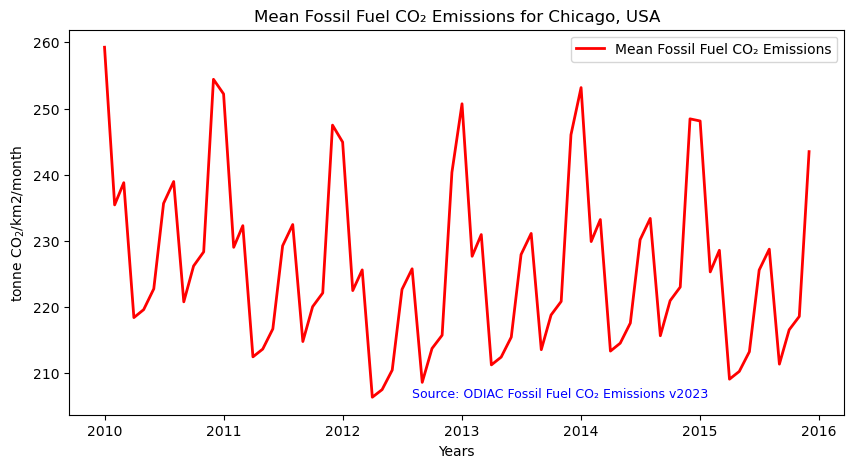

In [19]:
# Figure size: 20 representing the width, 10 representing the height
fig = plt.figure(figsize=(10,5))

# Use which_stat to pick which statisticm from our DataFrame to visualize
which_stat = "mean"

plt.plot(
    df["date"], # X-axis: sorted datetime
    df[which_stat], # Y-axis: maximum CO₂ level
    color="red", # Line color
    linestyle="-", # Line style
    linewidth=2, # Line width
    label=f"{which_stat.capitalize()} {items[0].assets[asset_name].title}" # Legend label
)

# Display legend
plt.legend()

# Insert label for the X-axis
plt.xlabel("Years")

# Insert label for the Y-axis
plt.ylabel("tonne CO$_2$/km2/month")

# Insert title for the plot
plt.title(f"{which_stat.capitalize()} {items[0].assets[asset_name].title} for {aoi_name}")

###
# Add data citation
plt.text(
    df["date"].iloc[40],           # X-coordinate of the text
    df[which_stat].min(),              # Y-coordinate of the text
    # Text to be displayed
    f"Source: {collection.title}",                  
    fontsize=9,                             # Font size
    color="blue",                            # Text color
)

# Plot the time series
plt.show()

You can see emissions peak in winter in this time series, similarly to the Dual Map in the previous section!

## Summary

In this notebook we have successfully explored, analysed and visualized STAC collecetion for ODIAC C02 fossisl fuel emission (2023).

1.  Install and import the necessary libraries
2.  Fetch the collection from STAC collections using the appropriate endpoints
3.  Count the number of existing granules within the collection
4.  Map and compare the CO₂ levels for two distinctive months/years
5.  Generate zonal statistics for the area of interest (AOI)
6.  Visualizing the Data as a Time Series

If you have any questions regarding this user notebook, please contact us using the [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSeVWCrnca08Gt_qoWYjTo6gnj1BEGL4NCUC9VEiQnXA02gzVQ/viewform).